In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils import data
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.1307, ), (.3081, ))])
train_data = datasets.MNIST("~/.pytorch", transform=transform, download=True)
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

In [15]:
print(train_data[0][0].size())
print(train_data[0][0].max())
print(train_data[0][0].min())

torch.Size([1, 28, 28])
tensor(2.8215)
tensor(-0.4242)


In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
         
        # hardcoded channels
        self.conv_block = nn.Sequential(nn.Conv2d(1, 32, 3, stride=2), 
                                        nn.ELU(), nn.Dropout(p=0.5),
                                        nn.Conv2d(32, 64, 3, stride=2),
                                        nn.ELU(), nn.Dropout(p=0.5))
        
        self.clf = nn.Sequential(nn.Linear(64*6*6, 1))
        
              
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv_block(x)
        x = x.view(-1, 64*6*6)
        x = self.clf(x)
        return x

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 64, 3),
            nn.SELU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.SELU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.SELU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), 
            nn.SELU()
        )
        
    def forward(self, z):
        x = self.model(z.view(-1, 100, 1, 1))
        return x

    @torch.no_grad()
    def generate(self):
        z = torch.randn(batch_size, 100)
        z = z.to(self.model[0].weight.device)
        raw = self.forward(z)
        return raw.clamp_(-0.4242, 2.8215) 

In [18]:
D = Discriminator()
G = Generator()

D.to(device)
G.to(device)


print(D)

print("------------------")

print(G)


opt_D = torch.optim.Adam(D.parameters(), lr=1e-3)
opt_G = torch.optim.Adam(G.parameters(), lr=1e-3)

Discriminator(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.5, inplace=False)
  )
  (clf): Sequential(
    (0): Linear(in_features=2304, out_features=1, bias=True)
  )
)
------------------
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): SELU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): SELU()
    (4): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (5): SELU()
    (6): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): SELU()
  )
)


In [19]:
criterion = nn.BCEWithLogitsLoss()

In [20]:
def update_D(D, G, x, y, noise, criterion):
    x = x.to(device)      
    label = torch.ones(y.size())
    label = label.to(device)
    out_real = D(x).view(-1)
    err_D_real = criterion(out_real, label)
    err_D_real.backward()
            
    out_fake = G(noise).reshape(batch_size, -1, 28, 28)
    label = torch.zeros(batch_size)
    label = label.to(device)
    out_ = D(out_fake).view(-1)
    err_D_fake = criterion(out_, label)
    err_D_fake.backward() 
        
    err_D = err_D_real + err_D_fake
    return err_D, out_fake

def update_G(D, G, noise, criterion):
    out_fake = G(noise).reshape(batch_size, -1, 28, 28)
    label = torch.ones(batch_size)
    label = label.to(device)
    pred = D(out_fake).view(-1)
    err_G = criterion(pred, label)
    err_G.backward()
    return err_G

def update_Gan(loader, D, G, opt_D, opt_G, criterion):
    errors_D = []
    errors_G = []
         
    for i, (x, y) in enumerate(loader):
        noise = torch.randn(batch_size, 100, 1, 1)
        noise = noise.to(device)
        
        G.requires_grad = False
        opt_D.zero_grad()
        err_D, out_fake = update_D(D, G, x, y, noise, criterion)
        errors_D.append(err_D.item())
        opt_D.step()
        
        G.requires_grad = True
        opt_G.zero_grad()
        err_G = update_G(D, G, noise, criterion)
        errors_G.append(err_G.item())
        opt_G.step()
        
    return errors_D, errors_G


def train_gan(D, G, opt_D, opt_G, criterion, loader, nr_epochs=30, every=10):
    for epoch in range(nr_epochs):
        if epoch % every == 0:
            G.eval()
            samples = G.generate().cpu().detach().numpy()
            plot_digits(samples)
            
        D.train()
        G.train()
        errs_D, errs_G = update_Gan(loader, D, G, opt_D, opt_G, criterion)
        print(f"epoch: {epoch+1} ,   err_D: {sum(errs_D)/len(errs_D)},   err_G: {sum(errs_G)/len(errs_G)}")

In [21]:
def plot_digits(samples):
    fig = plt.figure(figsize=(16, 8))
    for i in range(10):
        fig.add_subplot(1, 10, i+1)
        plt.imshow(samples[i][0], cmap="gray")
    plt.show()

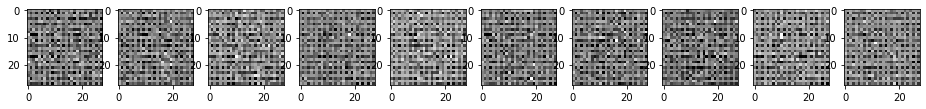

epoch: 1 ,   err_D: 0.4945378129426112,   err_G: 7.2229944239420165
epoch: 2 ,   err_D: 0.4812478310565577,   err_G: 5.339520973437376
epoch: 3 ,   err_D: 0.4554005188664902,   err_G: 5.443711252354864
epoch: 4 ,   err_D: 0.6670586950838693,   err_G: 4.612400067386343
epoch: 5 ,   err_D: 0.6338662257326692,   err_G: 4.137652714877749
epoch: 6 ,   err_D: 0.6496406882715378,   err_G: 3.9740050248245695
epoch: 7 ,   err_D: 0.6681851538767947,   err_G: 3.7063978130120967
epoch: 8 ,   err_D: 0.7010257802983083,   err_G: 3.2808513720152477
epoch: 9 ,   err_D: 0.7478490011460746,   err_G: 3.0094222150631804
epoch: 10 ,   err_D: 0.7810812651284976,   err_G: 2.7924249882637056


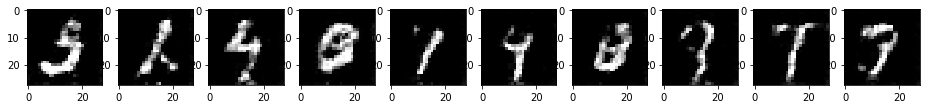

epoch: 11 ,   err_D: 0.8330875674862344,   err_G: 2.6040071828533082
epoch: 12 ,   err_D: 0.8764945613359337,   err_G: 2.428003162844603
epoch: 13 ,   err_D: 0.8958115872543758,   err_G: 2.2648521809181426
epoch: 14 ,   err_D: 0.9120863862256251,   err_G: 2.206603366555944
epoch: 15 ,   err_D: 0.9426695095704817,   err_G: 2.113612774084372
epoch: 16 ,   err_D: 0.969002878996355,   err_G: 2.021512010966791
epoch: 17 ,   err_D: 0.9965142419597487,   err_G: 1.9091321940361055
epoch: 18 ,   err_D: 1.0285502617547253,   err_G: 1.803761463937983
epoch: 19 ,   err_D: 1.0554551136519101,   err_G: 1.7358230864569577
epoch: 20 ,   err_D: 1.0730375110594703,   err_G: 1.6966884764018597


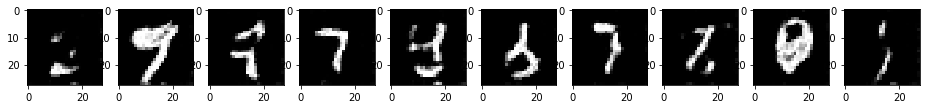

epoch: 21 ,   err_D: 1.0837053755707324,   err_G: 1.6263866362287038
epoch: 22 ,   err_D: 1.0909760270926998,   err_G: 1.5941357946853394
epoch: 23 ,   err_D: 1.1062704830535695,   err_G: 1.5610668856197838
epoch: 24 ,   err_D: 1.1150927354913276,   err_G: 1.5416308047929044
epoch: 25 ,   err_D: 1.1163169653939287,   err_G: 1.5236079509832712
epoch: 26 ,   err_D: 1.1232526187322287,   err_G: 1.5067210583798667
epoch: 27 ,   err_D: 1.1273547044949237,   err_G: 1.4688826191272817
epoch: 28 ,   err_D: 1.1365616341262483,   err_G: 1.4617150863096404
epoch: 29 ,   err_D: 1.1262093955265688,   err_G: 1.4580186383683544
epoch: 30 ,   err_D: 1.1459498476626269,   err_G: 1.4694835114707825


In [22]:
train_gan(D, G, opt_D, opt_G, criterion, train_loader)

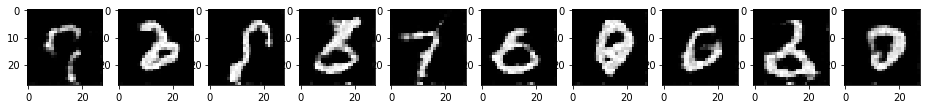

In [23]:
G.eval()
samples = G.generate().cpu().detach().numpy()
plot_digits(samples)